In [4]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

Using TensorFlow backend.


In [5]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

In [6]:
df = pd.read_csv("../input/creditcard.csv")

In [7]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.shape

(284807, 31)

In [9]:
# No of null values in dataset
df.isnull().values.sum()

0

In [9]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

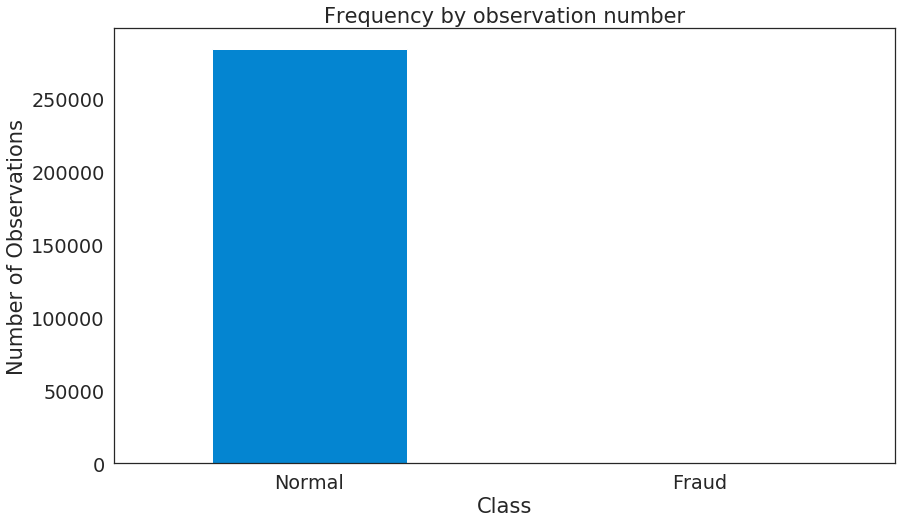

In [10]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(14, 8))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [12]:
normal_df = df[df['Class']==0]
fraud_df = df[df['Class']==1]

In [13]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [14]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

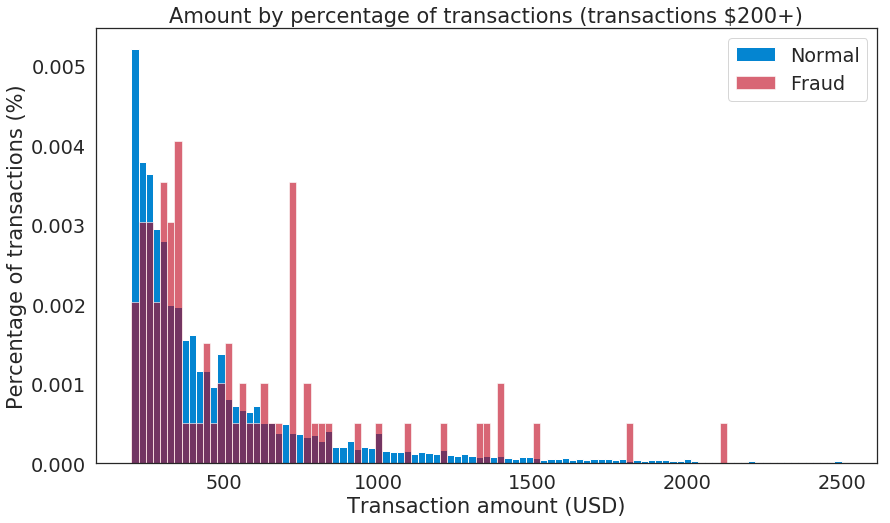

In [15]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.figure(figsize=(14, 8))
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

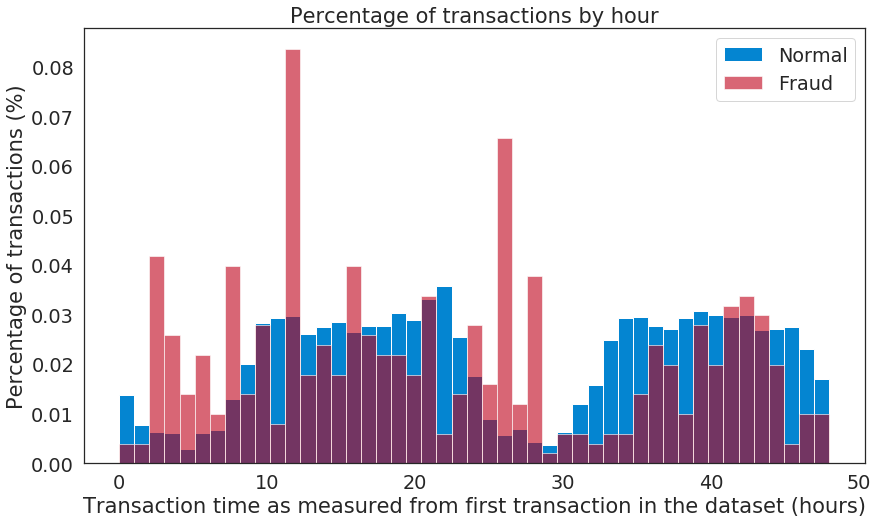

In [16]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(14, 8))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
# plt.hist((df.Time/(60*60)),bins)
plt.show()

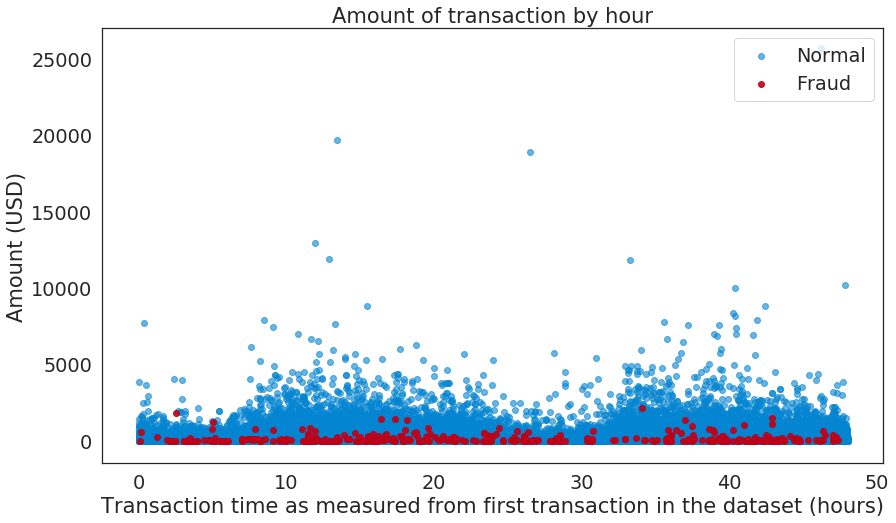

In [17]:
plt.figure(figsize=(14, 8))
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [19]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [20]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [23]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [25]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [26]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/50
227468/227468 [==============================] - 5s 20us/step - loss: 0.7755 - acc: 0.4950 - val_loss: 0.7238 - val_acc: 0.5636
Epoch 2/50
227468/227468 [==============================] - 4s 19us/step - loss: 0.6492 - acc: 0.5829 - val_loss: 0.6525 - val_acc: 0.6031
Epoch 3/50
227468/227468 [==============================] - 5s 21us/step - loss: 0.6075 - acc: 0.6139 - val_loss: 0.6318 - val_acc: 0.6311
Epoch 4/50
227468/227468 [==============================] - 4s 19us/step - loss: 0.5911 - acc: 0.6338 - val_loss: 0.6179 - val_acc: 0.6489
Epoch 5/50
227468/227468 [==============================] - 4s 19us/step - loss: 0.5802 - acc: 0.6457 - val_loss: 0.6107 - val_acc: 0.6433
Epoch 6/50
227468/227468 [==============================] - 4s 20us/step - loss: 0.5730 - acc: 0.6521 - val_loss: 0.6041 - val_acc: 0.6539
Epoch 7/50
227468/227468 [==============================] - 4s 19us/step - loss: 0.5675 - acc: 0.6544 - val_loss: 0

In [27]:
autoencoder = load_model('autoencoder_fraud.h5')

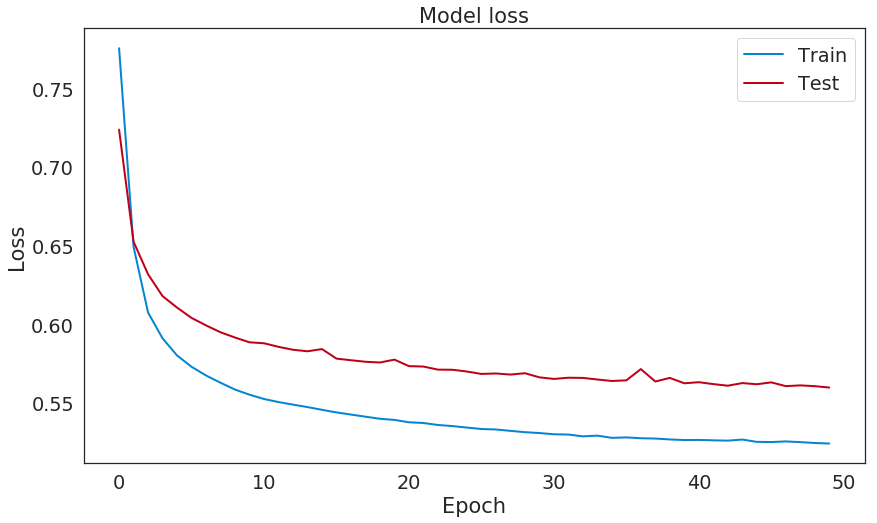

In [28]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [29]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.559688,0.002019
std,3.068561,0.044887
min,0.027059,0.000000
25%,0.156821,0.000000
50%,0.254564,0.000000
75%,0.431051,0.000000
max,198.289473,1.000000


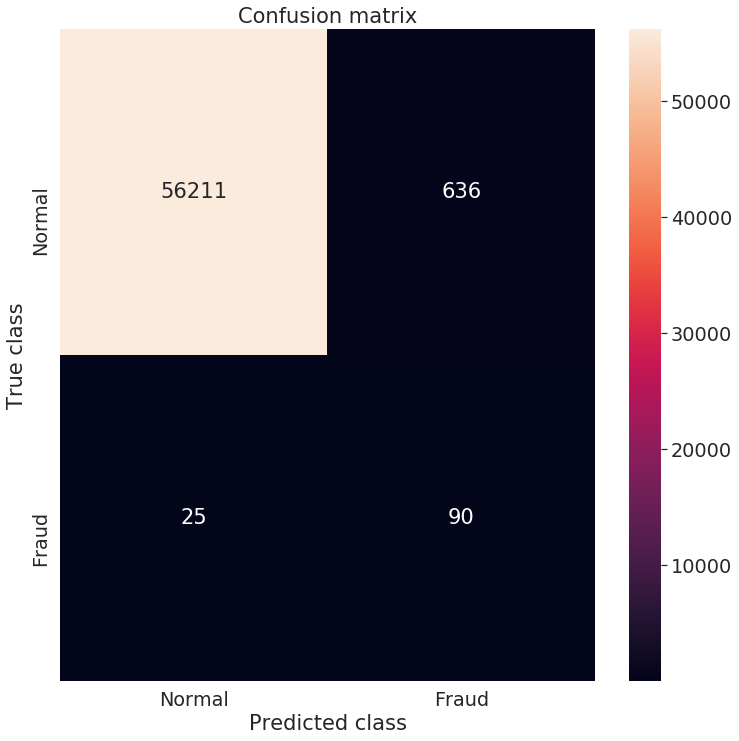

In [34]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Source: [datascience.com](http://www.datascience.com/blog/fraud-detection-with-tensorflow?utm_medium=email&_hsenc=p2ANqtz-9IZ7jpDKVn9-SJB_tVIKpBXp3QVcAC6cZivlugt6ptH8oHWCgodII9b0b_uC-Wyz3oVoXiPn4eBfDfEXqVPbPhHw1SaA&_hsmi=65196762&utm_content=65196762&utm_source=hs_email&hsCtaTracking=ed11a1c4-fe1e-4029-9f9c-fe0f8f753f9c%7C1d08bcf9-3f15-4273-a51c-a8369b589fe4)